# [Kaggle](https://www.kaggle.com/competitions/nlp-getting-started/overview)

In [1]:
import gc
from fastai.imports import *
from fastai.text.all import *

In [2]:
from kagtool.datasets.kaggle_downloader import KaggleDownloader

dataset_name = 'nlp-getting-started'
creds = ''

path = KaggleDownloader(dataset_name, creds).load_or_fetch_kaggle_dataset()
df = pd.read_csv(path/'train.csv')
df

nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1


In [3]:
bs=128

In [4]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),
    get_items=ColReader('text'),  # Assuming each item in your DataFrame is a text entry
    splitter=RandomSplitter(0.2)  # Randomly split the data into training and validation sets
).dataloaders(df, bs=bs, drop_last=True, shuffle=False)

if 'darwin' in platform.system().lower(): dls_lm.device = None

dls_lm.show_batch(max_n=3)
len(dls_lm.vocab), dls_lm.device

,text,text_
0,xxbos xxmaj top link : xxmaj reddit 's new content policy goes into effect many horrible subreddits banned or quarantined http : / / t.co / xxunk xxbos xxmaj truly a scene of chaos xxunk in xxunk . xxmaj pandemonium even . xxmaj utter xxunk . xxmaj that anyone survived such xxunk is xxunk . xxunk xxbos xxmaj xxunk xxmaj xxunk 's knee injury could xxunk xxmaj jazz 's xxunk - for,xxmaj top link : xxmaj reddit 's new content policy goes into effect many horrible subreddits banned or quarantined http : / / t.co / xxunk xxbos xxmaj truly a scene of chaos xxunk in xxunk . xxmaj pandemonium even . xxmaj utter xxunk . xxmaj that anyone survived such xxunk is xxunk . xxunk xxbos xxmaj xxunk xxmaj xxunk 's knee injury could xxunk xxmaj jazz 's xxunk - for xxunk
1,a xxmaj dream of xxmaj humanity ' xxunk by xxunk û _ û _ http : / / t.co / xxunk xxbos ' planted xxunk years ago ' it was moved to xxup u - s. xxmaj this xxmaj xxunk xxmaj survived xxmaj hiroshima xxmaj but xxmaj its xxmaj story xxmaj was xxmaj nearly xxmaj lost http : / / t.co / xxunk xxunk via xxunk xxbos # xxunk xxup u.s .,xxmaj dream of xxmaj humanity ' xxunk by xxunk û _ û _ http : / / t.co / xxunk xxbos ' planted xxunk years ago ' it was moved to xxup u - s. xxmaj this xxmaj xxunk xxmaj survived xxmaj hiroshima xxmaj but xxmaj its xxmaj story xxmaj was xxmaj nearly xxmaj lost http : / / t.co / xxunk xxunk via xxunk xxbos # xxunk xxup u.s . xxmaj
2,this . xxbos xxmaj all injuries xxmaj pre xxmaj foster / xxmaj floyd . xxmaj those will be covered next week . https : / / t.co / xxunk xxbos xxunk xxmaj hey xxmaj stephen xxmaj remember that time you drowned all the xxunk \n\n xxmaj read : http : / / t.co / xxunk xxbos xxunk for the record i m xxunk out the window early … i got xxunk body,. xxbos xxmaj all injuries xxmaj pre xxmaj foster / xxmaj floyd . xxmaj those will be covered next week . https : / / t.co / xxunk xxbos xxunk xxmaj hey xxmaj stephen xxmaj remember that time you drowned all the xxunk \n\n xxmaj read : http : / / t.co / xxunk xxbos xxunk for the record i m xxunk out the window early … i got xxunk body bagging


(3952, None)

In [5]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

# learn.lr_find()
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(3952, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(3952, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0-2): 3 x RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=3952, bias=True)
    (output_dp): RNNDropout()
  )
)

In [6]:
learn.fit_one_cycle(1, 5e-2)
learn.save('1epoch')
learn = learn.load('1epoch')
learn.unfreeze()
learn.fit_one_cycle(10, 5e-3)
learn.save_encoder('finetuned')

/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.045155,3.287371,0.426085,26.772390,00:33


/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.071996,3.084633,0.448763,21.859446,00:42
1,2.936670,2.987650,0.468099,19.838999,00:43
2,2.737832,3.063449,0.472396,21.401251,08:22
3,2.472211,3.120795,0.476063,22.664402,00:39
4,2.178889,3.169253,0.477322,23.789703,00:38
5,1.901013,3.305815,0.476628,27.270771,00:38
6,1.648637,3.379928,0.473372,29.368652,00:38
7,1.414544,3.462519,0.476280,31.897238,00:38
8,1.195374,3.596308,0.474935,36.463352,00:38
9,1.033792,3.593688,0.477040,36.367935,00:38


In [7]:
def predict_next(txt, learn):
    N_WORDS = 20
    N_SENTENCES = 5
    preds = [learn.predict(txt, N_WORDS, temperature=0.75) 
             for _ in range(N_SENTENCES)]
    print("\n".join(preds))

predict_next("Fire", learn)

/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-pac

/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-pac

/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-pac

/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-pac

/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-pac

Fire Burns On California U.s . China Economic Capital û _ : http :
Fire crews evacuate passengers from a Gold Coast tram trapped when others collided : http : / / t.co
Fire in Buffalo SW is 8 m Old Lady Lower Dies of Cramer
Fire burns two buildings on 2nd Street in # Manchester http : / / t.co / Fire
Fire truck and ambulance in NYC All Girls All Girls Just Girls Having


In [45]:
dls = DataBlock(
    blocks=(TextBlock.from_df('text', vocab=dls_lm.vocab), CategoryBlock),
    get_x=ColReader('text'),
    get_y=ColReader('target'),
    splitter=RandomSplitter(0.2)
).dataloaders(df, bs=32, num_workers=8)

dls.show_batch(max_n=3)

,text,category
0,xxbos _ xxunk xxrep 5 ? xxup xxunk xxunk xxrep 7 ? xxunk xxrep 5 ? xxup follow xxup all xxup who xxup rt xxunk xxrep 7 ? xxunk xxrep 5 ? xxup xxunk xxunk xxrep 7 ? xxunk xxrep 5 ? xxup xxunk xxup with xxunk xxrep 7 ? xxunk xxrep 5 ? xxup follow ? xxunk # xxup xxunk xxunk # xxup ty,0
1,xxbos xxmaj truth … \n https : / / t.co / xxunk xxunk # xxmaj news xxunk # xxup bbc xxunk # xxup cnn xxunk # xxmaj islam xxunk # xxmaj truth xxunk # god xxunk # xxup isis xxunk # terrorism xxunk # xxmaj quran xxunk # xxmaj lies http : / / t.co / xxunk,1
2,xxbos xxmaj truth … \n https : / / t.co / xxunk xxunk # xxmaj news xxunk # xxup bbc xxunk # xxup cnn xxunk # xxmaj islam xxunk # xxmaj truth xxunk # god xxunk # xxup isis xxunk # terrorism xxunk # xxmaj quran xxunk # xxmaj lies http : / / t.co / xxunk,0


SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(3952, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(3952, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0-2): 3 x RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.16000000000000003, inplace=False)
        (2): Linear(in_features=1200, out_features=50, bias=False)
        (3): ReLU(inplace=True)
      )
      (1): LinBnDrop(


/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


SuggestedLRs(valley=0.0014454397605732083)

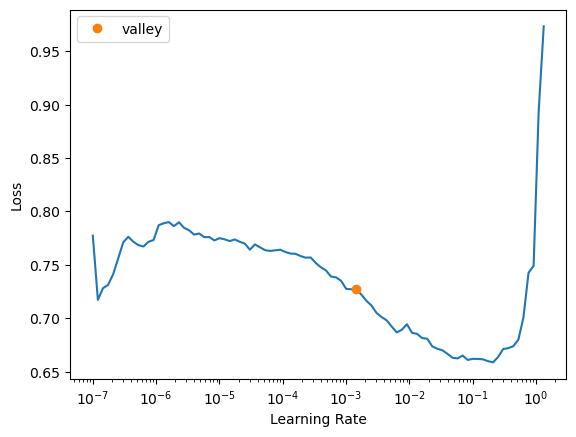

In [46]:
try:
    gc.collect()
    del learn
except: pass

learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.4, 
                                metrics=accuracy).to_fp16()

learn = learn.load_encoder('finetuned')
print(learn.model)
learn.lr_find()

In [47]:
# Initial training with all layers frozen except the final classifier layers
learn.fit_one_cycle(1, 1e-3, wd=1e-2)

/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,time
0,0.536797,0.481152,0.765440,00:09


In [48]:
# Freeze all layers except the last two
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2 / (2.6 ** 4), 1e-2), wd=1e-2)

# Freeze all layers except the last three
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3 / (2.6 ** 4), 5e-3), wd=1e-2)

# Unfreeze all layers and fine-tune the entire model
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-3 / (2.6 ** 4), 1e-3), wd=1e-2)

/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,time
0,0.506742,0.452837,0.798292,00:10


/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,time
0,0.483780,0.445159,0.803548,00:13


/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,time
0,0.410593,0.444920,0.804862,00:16
1,0.379414,0.473237,0.812746,00:16
2,0.353666,0.485051,0.805519,00:16
3,0.285198,0.528499,0.809461,00:16
4,0.247618,0.618593,0.795007,00:16


KeyboardInterrupt: 

### Kaggle Submission

In [10]:
tst_df = pd.read_csv(path/'test.csv')
tst_dl = learn.dls.test_dl(tst_df)
preds = learn.get_preds(dl=tst_dl)[0]

def subm(preds, suff):
    tst_df['target'] = preds.argmax(dim=1)
    sub_df = tst_df[['id','target']]
    sub_df.to_csv(f'sub-{suff}.csv', index=False)

subm(preds, 'lstm')

/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


# Random Forest With Embeddings

In [11]:
learn.dls.train_ds

(#6091) [(TensorText([   2,    8,  919,  564,   20, 3542,   14,  435,   18,   33, 2900,
               0,  783,    5,  110,   21]), TensorCategory(0)),(TensorText([   2,    8, 1148,    9,    8,   69,    8,    0,   28,    0,    8,
             587,    8, 2023,   28,    8,  290,    8, 1634,    8,    0,   19,
               8,    0,    8, 2287,   26,   12,   10,    9,    9,   11,    9,
               0,   12,   10,    9,    9,   11,    9,    0]), TensorCategory(1)),(TensorText([   2,   24,  164, 1157, 2360,   17,    8,    0,    8, 2788,   24,
               7,    0,    7, 2788,  475,   16,  164,   23, 2360,  325,  460,
               0, 3451,    8,   14,  117,    0,   46,   12,   10,    9,    9,
              11,    9,    0]), TensorCategory(1)),(TensorText([   2,    8, 1590,    8,  520,    8,   75,   74,    8,  740,    8,
             339,    8,  941,    8,   91,    8, 3436,   31,    8,    0,   19,
               8,  121,   17,    8,   76,    7,    0,    8,  464,    8,    0,
            

In [12]:
learn.model

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(3952, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(3952, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0-2): 3 x RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.16000000000000003, inplace=False)
        (2): Linear(in_features=1200, out_features=50, bias=False)
        (3): ReLU(inplace=True)
      )
      (1): LinBnDrop(


In [13]:
learn.model[0].module

AWD_LSTM(
  (encoder): Embedding(3952, 400, padding_idx=1)
  (encoder_dp): EmbeddingDropout(
    (emb): Embedding(3952, 400, padding_idx=1)
  )
  (rnns): ModuleList(
    (0): WeightDropout(
      (module): LSTM(400, 1152, batch_first=True)
    )
    (1): WeightDropout(
      (module): LSTM(1152, 1152, batch_first=True)
    )
    (2): WeightDropout(
      (module): LSTM(1152, 400, batch_first=True)
    )
  )
  (input_dp): RNNDropout()
  (hidden_dps): ModuleList(
    (0-2): 3 x RNNDropout()
  )
)

In [14]:
dls.dataset.tfms[0].tokenizer

Tokenizer:
encodes: (Path,object) -> encodes
(str,object) -> encodes
decodes: (object,object) -> decodes

In [15]:
AWD_LSTM??

Init signature:
AWD_LSTM(
    vocab_sz: 'int',
    emb_sz: 'int',
    n_hid: 'int',
    n_layers: 'int',
    pad_token: 'int' = 1,
    hidden_p: 'float' = 0.2,
    input_p: 'float' = 0.6,
    embed_p: 'float' = 0.1,
    weight_p: 'float' = 0.5,
    bidir: 'bool' = False,
)
Source:        
class AWD_LSTM(Module):
    "AWD-LSTM inspired by https://arxiv.org/abs/1708.02182"
    initrange=0.1

    def __init__(self, 
        vocab_sz:int, # Size of the vocabulary
        emb_sz:int, # Size of embedding vector
        n_hid:int, # Number of features in hidden state
        n_layers:int, # Number of LSTM layers
        pad_token:int=1, # Padding token id
        hidden_p:float=0.2, # Dropout probability for hidden state between layers
        input_p:float=0.6, # Dropout probability for LSTM stack input
        embed_p:float=0.1, # Embedding layer dropout probabillity
        weight_p:float=0.5, # Hidden-to-hidden wight dropout probability for LSTM layers
        bidir:bool=False # If set to

In [16]:
from fastai.text.all import *
import torch
import pandas as pd

def extract_text_embeddings(learner, dl):
    texts = dl.dataset.items['text'].tolist()  # Extract text column from DataFrame
    embeddings = []

    # Get the tokenizer and numericalizer from the DataLoaders
    tokenizer = dl.dataset.tfms[0].tokenizer
    numericalizer = dl.numericalize

    # Access the embedding layer from the AWD_LSTM model
    embedding_layer = learner.model[0].module.encoder

    for text in texts:
        # Tokenize the text
        tokens = tokenizer([text])[0]
        # Numericalize the tokens
        numericalized = tensor(numericalizer(tokens)).unsqueeze(0).to(learner.dls.device)

        # Get embeddings using the embedding layer
        with torch.no_grad():
            embeddings_tensor = embedding_layer(numericalized)
            embedding = embeddings_tensor.mean(dim=1).cpu().numpy()  # Mean pooling over the sequence length
        embeddings.append(embedding)

    # Convert embeddings to DataFrame
    embedding_df = pd.DataFrame(np.vstack(embeddings), columns=[f'emb_{i}' for i in range(embeddings[0].shape[1])])
    return embedding_df

# Example usage
# Assuming learn is your learner object and dls is your DataLoaders
embedded_text_train_df = extract_text_embeddings(learn, dls.train)
embedded_text_valid_df = extract_text_embeddings(learn, dls.valid)

# Verify the shape of the resulting DataFrames
print(embedded_text_train_df.shape, embedded_text_valid_df.shape)
embedded_text_train_df

(6091, 400) (1522, 400)


,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_390,emb_391,emb_392,emb_393,emb_394,emb_395,emb_396,emb_397,emb_398,emb_399
0,-0.034183,-0.028445,0.026426,0.070351,-0.063002,0.078609,-0.019157,-0.263661,-0.056502,0.060781,...,-0.029279,0.030145,0.000772,-0.022329,-0.015441,0.146932,-0.002725,0.012273,-0.039030,-0.056550
1,-0.007141,0.102240,0.077724,0.108877,-0.137661,0.252389,0.178327,-0.303554,-0.056530,0.218585,...,-0.027753,0.096219,0.143482,0.030739,0.027956,0.027284,-0.045246,0.081974,0.277017,-0.061442
2,-0.085716,0.040413,-0.011065,0.076396,-0.062790,0.072354,0.130806,-0.230223,-0.025018,0.145530,...,-0.069291,0.092060,0.037058,-0.018767,0.018342,0.047074,-0.030460,0.030900,0.130267,-0.053380
3,-0.086707,0.019600,-0.027758,0.063932,-0.095097,0.111422,0.115529,-0.280657,-0.011152,0.288354,...,-0.016040,0.120837,0.021732,-0.021828,-0.026521,0.106014,-0.014085,0.052972,0.203015,0.036189
4,0.022853,0.020545,0.033012,0.096078,-0.058596,0.077099,0.073410,-0.141959,-0.099903,0.259655,...,-0.130409,0.157641,-0.089053,0.005738,-0.076420,0.065658,0.050418,-0.017438,0.026353,0.070412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6086,0.065367,-0.020309,-0.017432,0.002117,0.021332,0.068432,0.045116,-0.244753,0.029292,0.188979,...,-0.002863,0.135913,-0.003287,-0.042199,-0.000557,0.009207,0.026914,0.036417,0.080097,0.097813
6087,-0.013671,0.027028,-0.024378,0.129615,-0.017604,0.013615,0.121575,-0.403670,0.133510,0.270534,...,-0.015863,0.092178,-0.014462,-0.070922,-0.032325,-0.044633,-0.063741,0.016771,-0.102552,0.101940
6088,0.060602,0.015483,-0.026816,0.061389,-0.101071,0.195014,0.084519,-0.220690,-0.120597,0.128546,...,-0.052578,-0.008985,0.101729,0.041420,0.008364,-0.036131,-0.053305,0.049233,0.275304,-0.082848
6089,0.029968,0.008605,-0.005549,0.028587,0.006650,0.078267,0.103960,-0.199022,0.028620,0.208258,...,-0.017471,0.124545,0.067195,-0.006884,-0.018684,-0.161837,-0.021244,0.028774,0.032378,0.068750


In [17]:
len(learn.dls.train.dataset.items), len(learn.dls.valid.dataset.items)

(6091, 1522)

In [18]:
embedded_text_train_df.head()

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_390,emb_391,emb_392,emb_393,emb_394,emb_395,emb_396,emb_397,emb_398,emb_399
0,-0.034183,-0.028445,0.026426,0.070351,-0.063002,0.078609,-0.019157,-0.263661,-0.056502,0.060781,...,-0.029279,0.030145,0.000772,-0.022329,-0.015441,0.146932,-0.002725,0.012273,-0.039030,-0.056550
1,-0.007141,0.102240,0.077724,0.108877,-0.137661,0.252389,0.178327,-0.303554,-0.056530,0.218585,...,-0.027753,0.096219,0.143482,0.030739,0.027956,0.027284,-0.045246,0.081974,0.277017,-0.061442
2,-0.085716,0.040413,-0.011065,0.076396,-0.062790,0.072354,0.130806,-0.230223,-0.025018,0.145530,...,-0.069291,0.092060,0.037058,-0.018767,0.018342,0.047074,-0.030460,0.030900,0.130267,-0.053380
3,-0.086707,0.019600,-0.027758,0.063932,-0.095097,0.111422,0.115529,-0.280657,-0.011152,0.288354,...,-0.016040,0.120837,0.021732,-0.021828,-0.026521,0.106014,-0.014085,0.052972,0.203015,0.036189
4,0.022853,0.020545,0.033012,0.096078,-0.058596,0.077099,0.073410,-0.141959,-0.099903,0.259655,...,-0.130409,0.157641,-0.089053,0.005738,-0.076420,0.065658,0.050418,-0.017438,0.026353,0.070412


In [19]:
len(df), len(embedded_text_train_df), len(embedded_text_valid_df)

(7613, 6091, 1522)

In [20]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [21]:
embedded_text_train_df.head()

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_390,emb_391,emb_392,emb_393,emb_394,emb_395,emb_396,emb_397,emb_398,emb_399
0,-0.034183,-0.028445,0.026426,0.070351,-0.063002,0.078609,-0.019157,-0.263661,-0.056502,0.060781,...,-0.029279,0.030145,0.000772,-0.022329,-0.015441,0.146932,-0.002725,0.012273,-0.039030,-0.056550
1,-0.007141,0.102240,0.077724,0.108877,-0.137661,0.252389,0.178327,-0.303554,-0.056530,0.218585,...,-0.027753,0.096219,0.143482,0.030739,0.027956,0.027284,-0.045246,0.081974,0.277017,-0.061442
2,-0.085716,0.040413,-0.011065,0.076396,-0.062790,0.072354,0.130806,-0.230223,-0.025018,0.145530,...,-0.069291,0.092060,0.037058,-0.018767,0.018342,0.047074,-0.030460,0.030900,0.130267,-0.053380
3,-0.086707,0.019600,-0.027758,0.063932,-0.095097,0.111422,0.115529,-0.280657,-0.011152,0.288354,...,-0.016040,0.120837,0.021732,-0.021828,-0.026521,0.106014,-0.014085,0.052972,0.203015,0.036189
4,0.022853,0.020545,0.033012,0.096078,-0.058596,0.077099,0.073410,-0.141959,-0.099903,0.259655,...,-0.130409,0.157641,-0.089053,0.005738,-0.076420,0.065658,0.050418,-0.017438,0.026353,0.070412


In [22]:
embedded_text_df = pd.concat([embedded_text_train_df, embedded_text_valid_df])
embedded_text_df

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_390,emb_391,emb_392,emb_393,emb_394,emb_395,emb_396,emb_397,emb_398,emb_399
0,-0.034183,-0.028445,0.026426,0.070351,-0.063002,0.078609,-0.019157,-0.263661,-0.056502,0.060781,...,-0.029279,0.030145,0.000772,-0.022329,-0.015441,0.146932,-0.002725,0.012273,-0.039030,-0.056550
1,-0.007141,0.102240,0.077724,0.108877,-0.137661,0.252389,0.178327,-0.303554,-0.056530,0.218585,...,-0.027753,0.096219,0.143482,0.030739,0.027956,0.027284,-0.045246,0.081974,0.277017,-0.061442
2,-0.085716,0.040413,-0.011065,0.076396,-0.062790,0.072354,0.130806,-0.230223,-0.025018,0.145530,...,-0.069291,0.092060,0.037058,-0.018767,0.018342,0.047074,-0.030460,0.030900,0.130267,-0.053380
3,-0.086707,0.019600,-0.027758,0.063932,-0.095097,0.111422,0.115529,-0.280657,-0.011152,0.288354,...,-0.016040,0.120837,0.021732,-0.021828,-0.026521,0.106014,-0.014085,0.052972,0.203015,0.036189
4,0.022853,0.020545,0.033012,0.096078,-0.058596,0.077099,0.073410,-0.141959,-0.099903,0.259655,...,-0.130409,0.157641,-0.089053,0.005738,-0.076420,0.065658,0.050418,-0.017438,0.026353,0.070412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1517,0.082430,0.036495,-0.000544,0.049103,-0.079622,0.057562,-0.000563,-0.196848,-0.062231,0.092967,...,0.110739,0.072549,0.115268,-0.087309,-0.105231,0.015131,-0.014992,0.042365,0.062360,0.028131
1518,0.105432,-0.025051,0.024132,0.075988,-0.043869,0.193176,0.140545,-0.266746,-0.085535,0.094690,...,-0.016935,0.083398,0.131557,0.030973,0.049750,-0.120442,-0.051325,0.115229,0.097282,-0.131696
1519,0.036151,0.014805,-0.015719,0.086286,0.053458,0.032042,0.037615,-0.216149,0.055952,0.177951,...,-0.037571,0.217078,0.008346,-0.013909,-0.031338,-0.020781,-0.021993,-0.021915,-0.143232,0.038254
1520,-0.068939,-0.061271,0.078244,0.070861,-0.005734,0.065245,0.131465,-0.213985,0.015492,0.253771,...,-0.073032,0.129164,0.033144,-0.015675,0.008714,0.079133,-0.019993,0.009030,0.072349,0.129819


In [23]:
len(df), len(embedded_text_df)

(7613, 7613)

In [24]:
import pandas as pd

# Assuming df and embedded_text_df are your DataFrames

# Reset indices to ensure they are unique and aligned
df_reset = df.reset_index(drop=True)
embedded_text_df_reset = embedded_text_df.reset_index(drop=True)

# Concatenate DataFrames along columns
df_with_embeds = pd.concat([df_reset, embedded_text_df_reset], axis=1)

# Verify the concatenated DataFrame
df_with_embeds

,id,keyword,location,text,target,emb_0,emb_1,emb_2,emb_3,emb_4,...,emb_390,emb_391,emb_392,emb_393,emb_394,emb_395,emb_396,emb_397,emb_398,emb_399
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,-0.034183,-0.028445,0.026426,0.070351,-0.063002,...,-0.029279,0.030145,0.000772,-0.022329,-0.015441,0.146932,-0.002725,0.012273,-0.039030,-0.056550
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,-0.007141,0.102240,0.077724,0.108877,-0.137661,...,-0.027753,0.096219,0.143482,0.030739,0.027956,0.027284,-0.045246,0.081974,0.277017,-0.061442
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,-0.085716,0.040413,-0.011065,0.076396,-0.062790,...,-0.069291,0.092060,0.037058,-0.018767,0.018342,0.047074,-0.030460,0.030900,0.130267,-0.053380
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,-0.086707,0.019600,-0.027758,0.063932,-0.095097,...,-0.016040,0.120837,0.021732,-0.021828,-0.026521,0.106014,-0.014085,0.052972,0.203015,0.036189
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,0.022853,0.020545,0.033012,0.096078,-0.058596,...,-0.130409,0.157641,-0.089053,0.005738,-0.076420,0.065658,0.050418,-0.017438,0.026353,0.070412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,0.082430,0.036495,-0.000544,0.049103,-0.079622,...,0.110739,0.072549,0.115268,-0.087309,-0.105231,0.015131,-0.014992,0.042365,0.062360,0.028131
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,0.105432,-0.025051,0.024132,0.075988,-0.043869,...,-0.016935,0.083398,0.131557,0.030973,0.049750,-0.120442,-0.051325,0.115229,0.097282,-0.131696
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,0.036151,0.014805,-0.015719,0.086286,0.053458,...,-0.037571,0.217078,0.008346,-0.013909,-0.031338,-0.020781,-0.021993,-0.021915,-0.143232,0.038254
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1,-0.068939,-0.061271,0.078244,0.070861,-0.005734,...,-0.073032,0.129164,0.033144,-0.015675,0.008714,0.079133,-0.019993,0.009030,0.072349,0.129819


In [25]:
df_with_embeds.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'emb_0', 'emb_1',
       'emb_2', 'emb_3', 'emb_4',
       ...
       'emb_390', 'emb_391', 'emb_392', 'emb_393', 'emb_394', 'emb_395',
       'emb_396', 'emb_397', 'emb_398', 'emb_399'],
      dtype='object', length=405)

In [26]:
from fastai.data.transforms import *

splits = RandomSplitter(0.2)(df_with_embeds)
cats=["keyword","location",]
conts=[f'emb_{i}' for i in range(400)]
dep = 'target'

to = TabularPandas(
    df_with_embeds, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=cats,
    cont_names=conts,
    y_names=dep,
)

len(to.train),len(to.valid)

NameError: name 'TabularPandas' is not defined

In [ ]:
to.show()

,keyword,location,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64,emb_65,emb_66,emb_67,emb_68,emb_69,emb_70,emb_71,emb_72,emb_73,emb_74,emb_75,emb_76,emb_77,emb_78,emb_79,emb_80,emb_81,emb_82,emb_83,emb_84,emb_85,emb_86,emb_87,emb_88,emb_89,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99,emb_100,emb_101,emb_102,emb_103,emb_104,emb_105,emb_106,emb_107,emb_108,emb_109,emb_110,emb_111,emb_112,emb_113,emb_114,emb_115,emb_116,emb_117,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,emb_128,emb_129,emb_130,emb_131,emb_132,emb_133,emb_134,emb_135,emb_136,emb_137,emb_138,emb_139,emb_140,emb_141,emb_142,emb_143,emb_144,emb_145,emb_146,emb_147,emb_148,emb_149,emb_150,emb_151,emb_152,emb_153,emb_154,emb_155,emb_156,emb_157,emb_158,emb_159,emb_160,emb_161,emb_162,emb_163,emb_164,emb_165,emb_166,emb_167,emb_168,emb_169,emb_170,emb_171,emb_172,emb_173,emb_174,emb_175,emb_176,emb_177,emb_178,emb_179,emb_180,emb_181,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194,emb_195,emb_196,emb_197,emb_198,emb_199,emb_200,emb_201,emb_202,emb_203,emb_204,emb_205,emb_206,emb_207,emb_208,emb_209,emb_210,emb_211,emb_212,emb_213,emb_214,emb_215,emb_216,emb_217,emb_218,emb_219,emb_220,emb_221,emb_222,emb_223,emb_224,emb_225,emb_226,emb_227,emb_228,emb_229,emb_230,emb_231,emb_232,emb_233,emb_234,emb_235,emb_236,emb_237,emb_238,emb_239,emb_240,emb_241,emb_242,emb_243,emb_244,emb_245,emb_246,emb_247,emb_248,emb_249,emb_250,emb_251,emb_252,emb_253,emb_254,emb_255,emb_256,emb_257,emb_258,emb_259,emb_260,emb_261,emb_262,emb_263,emb_264,emb_265,emb_266,emb_267,emb_268,emb_269,emb_270,emb_271,emb_272,emb_273,emb_274,emb_275,emb_276,emb_277,emb_278,emb_279,emb_280,emb_281,emb_282,emb_283,emb_284,emb_285,emb_286,emb_287,emb_288,emb_289,emb_290,emb_291,emb_292,emb_293,emb_294,emb_295,emb_296,emb_297,emb_298,emb_299,emb_300,emb_301,emb_302,emb_303,emb_304,emb_305,emb_306,emb_307,emb_308,emb_309,emb_310,emb_311,emb_312,emb_313,emb_314,emb_315,emb_316,emb_317,emb_318,emb_319,emb_320,emb_321,emb_322,emb_323,emb_324,emb_325,emb_326,emb_327,emb_328,emb_329,emb_330,emb_331,emb_332,emb_333,emb_334,emb_335,emb_336,emb_337,emb_338,emb_339,emb_340,emb_341,emb_342,emb_343,emb_344,emb_345,emb_346,emb_347,emb_348,emb_349,emb_350,emb_351,emb_352,emb_353,emb_354,emb_355,emb_356,emb_357,emb_358,emb_359,emb_360,emb_361,emb_362,emb_363,emb_364,emb_365,emb_366,emb_367,emb_368,emb_369,emb_370,emb_371,emb_372,emb_373,emb_374,emb_375,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383,emb_384,emb_385,emb_386,emb_387,emb_388,emb_389,emb_390,emb_391,emb_392,emb_393,emb_394,emb_395,emb_396,emb_397,emb_398,emb_399,target
6192,sirens,#na#,0.037508,0.055060,0.010673,0.006946,-0.008763,0.026151,0.051637,-0.219186,-0.069657,0.288112,-0.040087,-0.145560,0.011004,0.055728,-0.023232,-0.031818,0.040715,-0.128729,0.164664,0.026755,-0.065879,0.015090,0.082089,-0.025161,0.003342,-0.093488,-0.148472,0.009366,0.068209,0.084896,0.093744,-0.028086,-0.141958,0.023407,-0.070239,-0.017203,0.150015,0.031332,0.081929,-0.031675,-0.066437,0.274757,0.023057,0.009700,0.023158,-0.125546,-0.024842,0.170423,0.152998,-0.030957,-0.169797,0.259338,-0.021894,0.083339,0.090397,-0.055111,0.165681,-0.006837,-0.111347,-0.055022,0.031371,-0.013222,-0.108863,-0.147274,-0.056070,0.111384,0.050492,0.045759,0.148347,-0.119919,-0.001030,-0.011712,-0.151017,0.021616,-0.077219,0.028097,0.012725,-0.064401,-0.072953,-0.134233,-0.257821,0.048635,0.030048,0.123441,0.052961,-0.019909,0.192906,0.023149,-0.146892,-0.030802,0.008137,0.0380

In [ ]:
to.items.head(3)

,id,keyword,location,text,target,emb_0,emb_1,emb_2,emb_3,emb_4,...,emb_390,emb_391,emb_392,emb_393,emb_394,emb_395,emb_396,emb_397,emb_398,emb_399
6192,8839,180,0,sleeping with sirens vai vir pra sp,0,0.490382,0.422509,-0.098451,-0.684747,0.717871,...,0.807239,1.018406,-1.775813,-1.177999,-0.019847,-0.090329,0.166692,-0.133344,-0.035306,0.188026
5447,7768,158,2644,$1 million bail for man accused of #shooting at Fife #police - Aug 5 @ 8:16 PM ET http://t.co/hu5CXqnoBf,1,1.658683,-0.434940,1.315403,-0.384109,0.109086,...,0.067902,-0.546903,0.672220,0.413047,0.709461,-0.439854,0.363564,1.255388,0.843311,-1.184751
4873,6937,141,1133,@BenignoVito @LibertyBell1000 HILLARYMASS MURDERER.,0,-0.391727,-2.019549,2.752736,-0.506640,-1.274974,...,-1.230838,-0.670749,1.182071,2.056793,1.852203,-0.745635,-2.137211,0.233751,2.048053,0.462029


In [ ]:
to.classes['keyword']

['#na#', 'ablaze', 'accident', 'aftershock', 'airplane%20accident', 'ambulance', 'annihilated', 'annihilation', 'apocalypse', 'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked', 'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze', 'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood', 'bloody', 'blown%20up', 'body%20bag', 'body%20bagging', 'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse', 'buildings%20burning', 'buildings%20on%20fire', 'burned', 'burning', 'burning%20buildings', 'bush%20fires', 'casualties', 'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency', 'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided', 'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew', 'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris', 'deluge', 'deluged', 'demolish', 'demolished', 'demolition', 'derail', 'derailed', 'derailment', 'desolate', 'desolation', 'destroy', 'destroyed', 'destruction', 'detonate', 'd

In [ ]:
to.classes['location']

['#na#', '  ', '  Glasgow ', '  Melbourne, Australia', '  News', '  å_ ', " 45å¡ 5'12.53N   14å¡ 7'24.93E", ' 616 \x89Û¢ Kentwood , MI ', ' ? ??????? ? ( ?? å¡ ? ? ? å¡)', ' ?currently writing a book?', ' Alberta', ' Alex/Mika/Leo|18|he/she/they', ' BC, US, Asia or Europe.', ' Baku & Erzurum ', ' Blood Indian Reserve', ' Bouvet Island', ' Eugene, Oregon', ' Indiana', ' Jariana Town', ' Little Rock, AR', ' Miami Beach', ' Nevada Carson City,Freeman St', ' Neverland ', ' New Delhi ', ' New England', ' Nxgerxa', ' Quantico Marine Base, VA.', ' Queensland, Australia', ' Road to the Billionaires Club', ' Somewhere.', ' The World', ' Tropical SE FLorida', ' snapchat // fvck_casper ', ' |IG: imaginedragoner', '#1 Vacation Destination,HAWAII', '#937??#734', '#????? Libya#', '#BlackLivesMatter', '#BossNation!', '#Bummerville otw', '#EngleWood CHICAGO ', '#FLIGHTCITY UK  ', '#ForeverWithBAP 8 ', '#GDJB #ASOT', '#Gladiator \x89Û¢860\x89Û¢757\x89Û¢', '#HAMont', '#HarleyChick#PJNT#RunBenRun', '#Kau

In [ ]:
to.items.head(3)

,id,keyword,location,text,target,emb_0,emb_1,emb_2,emb_3,emb_4,...,emb_390,emb_391,emb_392,emb_393,emb_394,emb_395,emb_396,emb_397,emb_398,emb_399
6192,8839,180,0,sleeping with sirens vai vir pra sp,0,0.490382,0.422509,-0.098451,-0.684747,0.717871,...,0.807239,1.018406,-1.775813,-1.177999,-0.019847,-0.090329,0.166692,-0.133344,-0.035306,0.188026
5447,7768,158,2644,$1 million bail for man accused of #shooting at Fife #police - Aug 5 @ 8:16 PM ET http://t.co/hu5CXqnoBf,1,1.658683,-0.434940,1.315403,-0.384109,0.109086,...,0.067902,-0.546903,0.672220,0.413047,0.709461,-0.439854,0.363564,1.255388,0.843311,-1.184751
4873,6937,141,1133,@BenignoVito @LibertyBell1000 HILLARYMASS MURDERER.,0,-0.391727,-2.019549,2.752736,-0.506640,-1.274974,...,-1.230838,-0.670749,1.182071,2.056793,1.852203,-0.745635,-2.137211,0.233751,2.048053,0.462029


In [ ]:
# save_pickle(path/'to.pkl',to)
# to = load_pickle(path/'to.pkl')

In [ ]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier

def random_forest(xs, y, n_estimators=100, min_samples_leaf=5):
    rf = RandomForestClassifier(n_estimators, min_samples_leaf=min_samples_leaf)
    rf.fit(xs, y);
    return rf
     

m = random_forest(xs, y)
mean_absolute_error(valid_y, m.predict(valid_xs))

0.4375821287779238

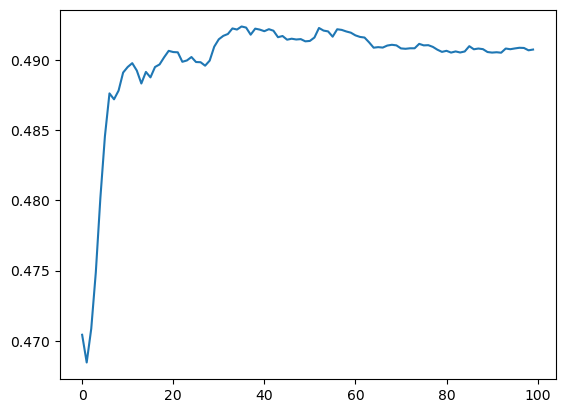

In [ ]:
# should we add more trees?
plt.plot([mean_absolute_error(preds[:i+1].mean(0), valid_y) for i in range(100)]);

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
mean_absolute_error(preds.mean(0), valid_y)

/Users/cactus/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/cactus/miniconda3/lib/python3.12/site-packages/sklearn/base.py:

0.483646517739816

We had 78% with LSTM and text column only, need to review what's going on in this solution, are the embedding what we expect?

Maybe there's an index mismatch with the original df when loading in to the random forest? TBD